In [42]:
import neuralfoil as nf
import aerosandbox.numpy as np
import aerosandbox as asb
import aerosandbox.tools.pretty_plots as p
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import casadi as ca

In [30]:
coor_airfoil = asb.Airfoil("NACA6412") # our basic airfoil we start optimization from

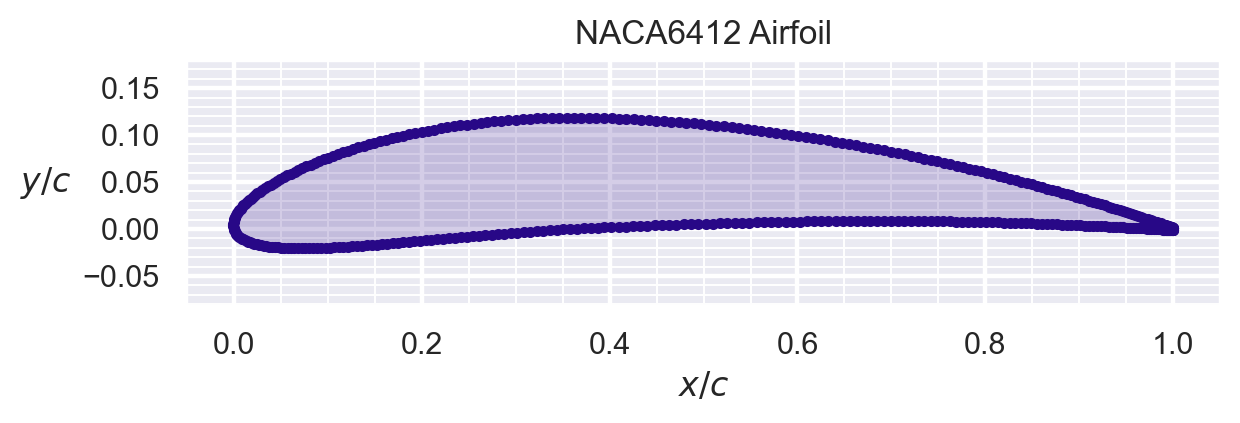

In [31]:
fig, ax = plt.subplots(figsize=(6,2))
coor_airfoil.draw()

In [32]:
speed_sound = 343 # m/s
current_velocity = 13.4 # m/s
mach = current_velocity/speed_sound

In [33]:
inital_airfoil_info = asb.XFoil(
        airfoil=coor_airfoil,
        Re=5e5,
        mach=mach,
        timeout=30,
    ).alpha(np.linspace(0, 15, 41), start_at=5)

# Iterative Optimization

In [34]:
airfoil_iterations = []
aero_iterations = []

In [35]:
test_iters = [1e5, 5e5, 1e6, 1e7, 1e10] # iterate for different Reynolds numbers
# we can iterate over anything, this is just a test

In [36]:
CL_multipoint_targets = np.arange(1.6, 2.8, 0.2)
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])
mach = 0.8 # roughly an airplane?

In [37]:
initial_airfoil = asb.KulfanAirfoil("NACA6412")
initial_airfoil.name = "initial guess"
last_airfoil = None

In [38]:
# function we need in the optimization
get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

In [39]:
for i in range(len(test_iters)):
    re = test_iters[i]
    Re_list = re*(CL_multipoint_targets/1.25)**-0.5 # not gonna lie, not sure why it does this
    if i == 0:
        # we are optimizing the initial airfoil
        current_guess = initial_airfoil
    else:
        current_guess = last_airfoil

    opti = asb.Opti()

    optimized_airfoil = asb.KulfanAirfoil(
        name = "Optimization #{}".format(i),
        lower_weights=opti.variable( # weights for the lower surface of airfoil
            init_guess = current_guess.lower_weights,
            lower_bound = -0.25,
            upper_bound = 0.5,
        ),
        upper_weights=opti.variable(
            init_guess = current_guess.upper_weights,
            lower_bound = -0.25,
            upper_bound = 0.5,
        ),
        leading_edge_weight=opti.variable(
            init_guess = current_guess.leading_edge_weight,
            lower_bound = 1,
            upper_bound = 1
        ),
        TE_thickness=0,
    )

    # we are letting alpha vary also
    # note to self: try to make more variables vary next time instead of iterating
    alpha = opti.variable(
        init_guess = np.degrees(CL_multipoint_targets/(2*np.pi)),
        lower_bound = -5,
        upper_bound = 18
    )

    aero = optimized_airfoil.get_aero_from_neuralfoil(
        alpha=alpha,
        Re=Re_list, # where we define our parameters
        mach=mach,
    )

    opti.subject_to([
        aero["analysis_confidence"] > 0.90,
        aero["CL"] == CL_multipoint_targets,
        aero["CM"] >= -0.133, # pitching moment
        np.diff(alpha) > 0,
        optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
        optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
        optimized_airfoil.TE_angle() >= 6.25,
        optimized_airfoil.lower_weights[0] < -0.05,
        optimized_airfoil.upper_weights[0] > 0.05,
        optimized_airfoil.local_thickness() > 0
    ])

    opti.subject_to(
        get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(current_guess)
    )

    opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

    sol = opti.solve(
        behavior_on_failure="return_last",
        options={
            "ipopt.mu_strategy": 'monotone',
            "ipopt.start_with_resto": 'yes'
        }
    )

    optimized_airfoil = sol(optimized_airfoil)
    aero = sol(aero)

    airfoil_iterations.append(optimized_airfoil)
    aero_iterations.append(aero)

    last_airfoil = optimized_airfoil

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2043
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      170
        inequality constraints with only lower bounds:      145
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0912169e+00 4.52e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

C:\Users\amcpo\anaconda3\Lib\site-packages\aerosandbox\optimization\opti.py:728: UserWarning: Optimization failed. Returning last solution.
  warnings.warn("Optimization failed. Returning last solution.")


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2043
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      170
        inequality constraints with only lower bounds:      145
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0478891e+00 1.86e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [41]:
len(airfoil_iterations)

5

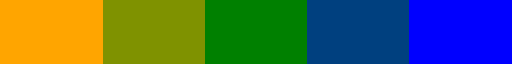

In [46]:
custom_cmap

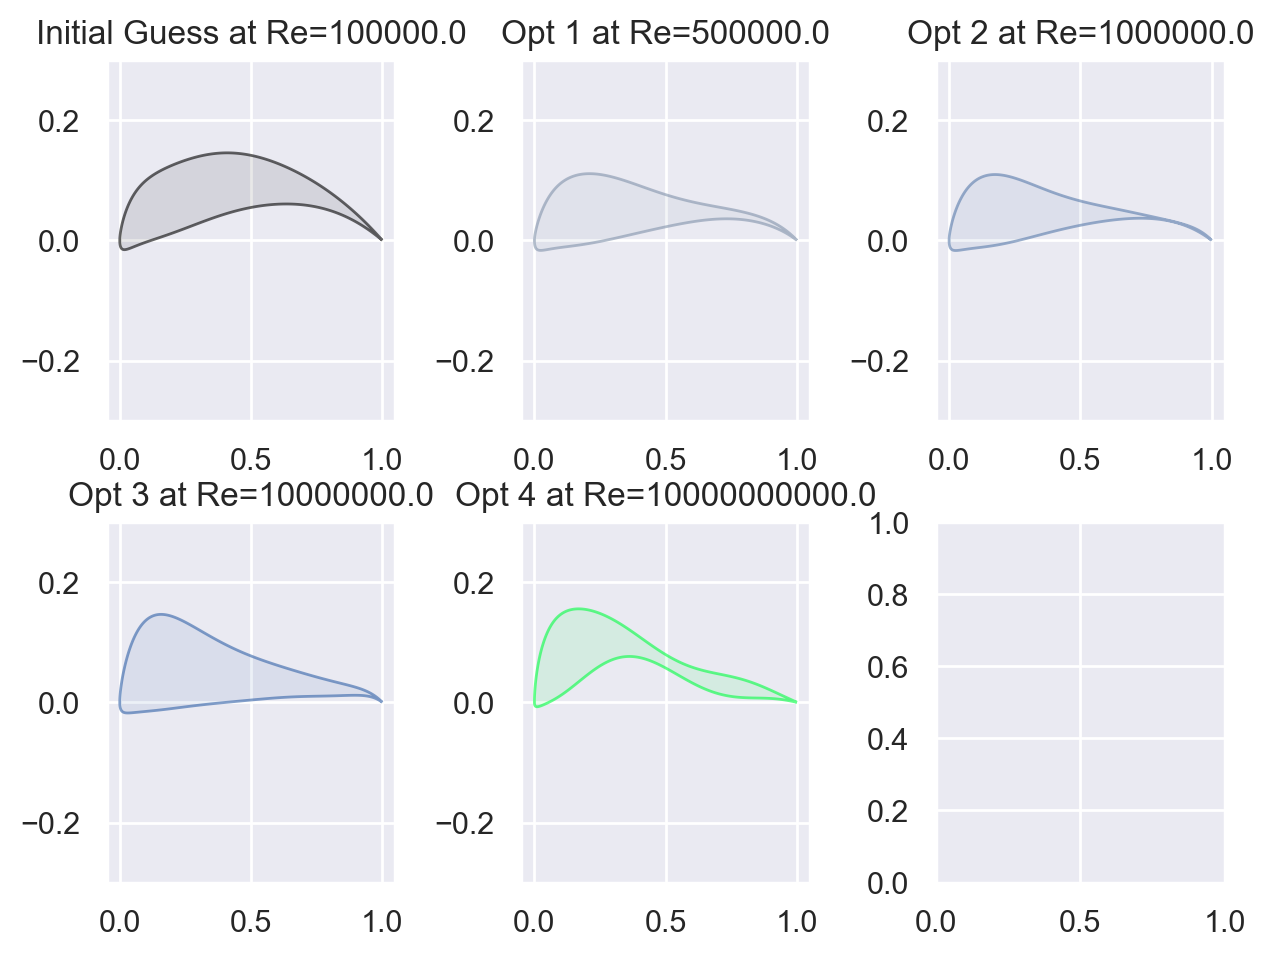

In [94]:
fig, ax = plt.subplots(2, 3)
fig.tight_layout()

colors = ['#000000', '#8293AB', '#597BAB', '#3262A8', '#00FF40']
names = ["Initial Guess", 'Opt 1', 'Opt 2', 'Opt 3', 'Opt 4']

for re_value, af, color, name, i, row, col in zip(test_iters, airfoil_iterations, colors, names, list(range(0,5)), [0,0,0,1,1], [0,1,2,0,1]):
    color = p.adjust_lightness(color, 1)
    ax[row][col].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name
    )
    ax[row][col].set_ylim(-0.3, 0.3)
    ax[row][col].set_title(str(name) + " at Re={}".format(re_value))    
